In [1]:
import sys

In [2]:
sys.executable

'/Users/averykrieger/Envs/test_env/bin/python'

In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
import my_project_skeleton.my_first_module as mfm

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'HELLOOO DUUUDE'}>)

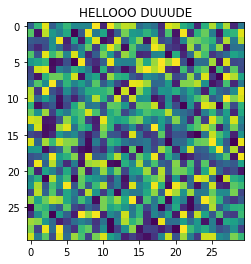

In [8]:
mfm.plot()

In [10]:
mfm.scream_at_me("hello")

HELLO
